# Uitleg Notebook 
Dit Notebook is om de EDU files in te lezen en op te slaan als h5 file in GitHub

## EDU files content 
korte beschrijving wat er in die data staat

### plan van aanpak 

#### csv file exporten naar Github
* temporary map aanmaken
* Link naar Data invoeren
* download de zipfile en plaats in temporary map
* Unzippen in temporary map
* cvs file selecteren die er toe doet: voorbeeld naam: profielen elektriciteit 2021 versie 1.00 of Prognoseprofielen-elektriciteit-2022-2023-2024-dd-2020
* van csv file Dataframe maken
* geselecteerd csv file plaatsen op Github, map data-raw, in nieuwe map genaamd EDU
* temp folder leeggooien
* herhalen voor alle zip files (in totaal zijn er 7 (6 profielen en 1 prognoseprofiel)


#### Excell file omzetten naar DF






In [1]:
import os  
import requests
import zipfile as zp
from zipfile import ZipFile  # importeer van de module zipfile de Class ZipFile
import matplotlib.pyplot as plt
import glob
from glob import glob
import pandas as pd

In [2]:
# temporary variable aanmaken voor eventuele temp map
tmp_directory = "temp_voor_EDU_files"

#parent_dir = os.getcwd() # commando voor get Current Working Directory
current_dir = os.getcwd()

# ga naar temp directory toe

if tmp_directory not in current_dir:
    path = os.path.join(current_dir, tmp_directory) # extra variabele onder notebook (=cwd) wordt nu gemaakt
    # maak temp directory als hij nog niet bestaat
    try:
        os.mkdir(path)  # extra directory onder notebook (=cwd) wordt nu gemaakt
        print(f"Directory created {tmp_directory}") 
    except:
        print ('directory bestaat al')
    
    os.chdir(path)  # veranderen naar de temp directory
print(os.getcwd())


Directory created temp_voor_EDU_files
c:\Users\ericr\OneDrive - Actondata\Projecten\jads_enexis\notebooks\temp_voor_EDU_files


In [3]:
def download_url(url, save_path, chunk_size=128): # downloaden in chuncks, stream, LET OP: path = directory + filenaam
    r = requests.get(url, stream=True)
    with open(save_path, 'wb') as fd:                    #wb = write binairy, text files gaan net iets anders (optimalisatie)
        for chunk in r.iter_content(chunk_size=chunk_size):
            fd.write(chunk)

In [4]:
EDU_files = [
    'http://www.nedu.nl/wp-content/uploads/2020/07/Profielen-elektriciteit-2021-versie-1.00-Platform-Verbruiksprofielen-NEDU-20200701-002.1.1.zip',
    'http://www.nedu.nl/wp-content/uploads/2019/07/Profielen-elektriciteit-2020-versie-1.00-Platform-Verbruiksprofielen-NEDU-20190703-002.1.1.zip',
    'http://www.nedu.nl/wp-content/uploads/2018/07/Profielen-Elektriciteit-2019-versie-1.00-ALV-NEDU-20180704-011.1.1.zip',
    'http://www.nedu.nl/wp-content/uploads/2017/07/Profielen-Elektriciteit-2018-versie-1.00-ALV-NEDU-20170705-011.1.1.zip',
    'http://www.nedu.nl/wp-content/uploads/2016/04/Profielen-Elektriciteit-2017-versie-1.00-ALV-NEDU-20160413-012.1.1.zip',
    'http://www.nedu.nl/wp-content/uploads/2015/09/Profielen-Elektriciteit-2016-versie-1.01-ALV-NEDU-20150916-012.2.zip',
    'http://www.deenergiemanager.nl/tools/profielen_E/E2010.zip',
    'http://www.deenergiemanager.nl/tools/profielen_E/E2011.zip',
    'http://www.deenergiemanager.nl/tools/profielen_E/E2012.zip',
    'http://www.deenergiemanager.nl/tools/profielen_E/E2013.zip',
    'http://www.deenergiemanager.nl/tools/profielen_E/E2014.zip',
    'http://www.deenergiemanager.nl/tools/profielen_E/E2015.zip',
]


for EDU_file in EDU_files:
    print (f"Downloading {EDU_file}")
    # definieren van variabele van de download URL
    save_path = EDU_file.split("/")[-1]

    # Haal het bestand op en sla het op in de temporary directory
    download_url(EDU_file, save_path)

    # Creer een ZipFile Object met het pad naar de zip file
    with ZipFile(save_path, 'r') as zipObj:
        # Extract de zip file naar de huidige directory
        zipObj.extractall(path=None, members=None, pwd=None)


In [5]:
combined_df = None
files = glob('**/profielen*.csv', recursive=True)  # resultaat = lijst met bestaandsnamen komt hier uit. Als er 1 bestandsnaam in zit is dit nog steeds een lijst. Dit zijn de profielen van de NEDU site
files.extend (glob('**/E*.csv', recursive=True)) # profielen van de energiemanager site. Zoek ook in subdirectories.

# itereer door alle csv bestanden met het patroon. 
for file in files:
    print (f"Processing {file}")
    # Haal de data uit de csv file. De eerste 4 rijen bevatten alleen een beschrijving en geen data
    # Behalve voor de 2010 profielen. Deze csv bevat 8 rijen met beschrijving
    df = pd.read_csv(file)
    if file == 'E2010.csv':
        df = df.drop([0,1,2,3,4,5,6,7,8])
    else:
        df = df.drop([0,1,2,3])

    # De namen van de kolommen
    df.columns = ('DatumTijd', 'Start','End','E1A','E1B','E1C','E2A','E2B','E3A','E3B','E3C','E3D','E4A')

    # De eerste kolom bevat het tijdstip van de meting. Deze hebben we ook niet nodig
    df = df.drop(['Start','End'], axis=1)

    # Reindex het dataframe zodat het bij index 0 begint
    df = df.reset_index(drop=True)

    if combined_df is None:
        combined_df = df.copy()
    else:
        combined_df = combined_df.append(df)

# Pas de kolom types aan
print ("Retyping kolommen")
combined_df.DatumTijd = pd.to_datetime(combined_df.DatumTijd, format='%d-%m-%Y %H:%M')
combined_df = combined_df.astype({'E1A':'float64','E1B':'float64','E1C':'float64','E2A':'float64','E2B':'float64','E3A':'float64','E3B':'float64','E3C':'float64','E3D':'float64','E4A':'float64'})

# Het dataframe hoeft niet gevuld te worden op volgorde van tijd. Het wordt gevuld op volgorde van het
# vinden van de bestanden door glob. Sorteer het daarom op de tijden in de start kolom
print ("Dataframe sorteren op datum")
combined_df = combined_df.sort_values(by='DatumTijd')

# Reindex het hele dataframe
combined_df = combined_df.reset_index(drop=True)
combined_df.info()

Processing profielen Elektriciteit 2016 versie 1.01.csv
Processing profielen elektriciteit 2017 versie 1.00.csv
Processing profielen Elektriciteit 2018 versie 1.00.csv
Processing profielen elektriciteit 2020 versie 1.00.csv
Processing profielen elektriciteit 2021 versie 1.00.csv
Processing Profielen Elektriciteit 2019 versie 1.00 (ALV NEDU 20180704-011.1.1)\profielen Elektriciteit 2019 versie 1.00.csv
Processing E2010.csv
Processing E2011.csv
Processing E2012.csv
Processing E2013.csv
Processing E2014.csv
Processing E2015.csv
Retyping kolommen
Dataframe sorteren op datum
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421015 entries, 0 to 421014
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   DatumTijd  420768 non-null  datetime64[ns]
 1   E1A        420768 non-null  float64       
 2   E1B        420768 non-null  float64       
 3   E1C        420768 non-null  float64       
 4   E2A        420768 n

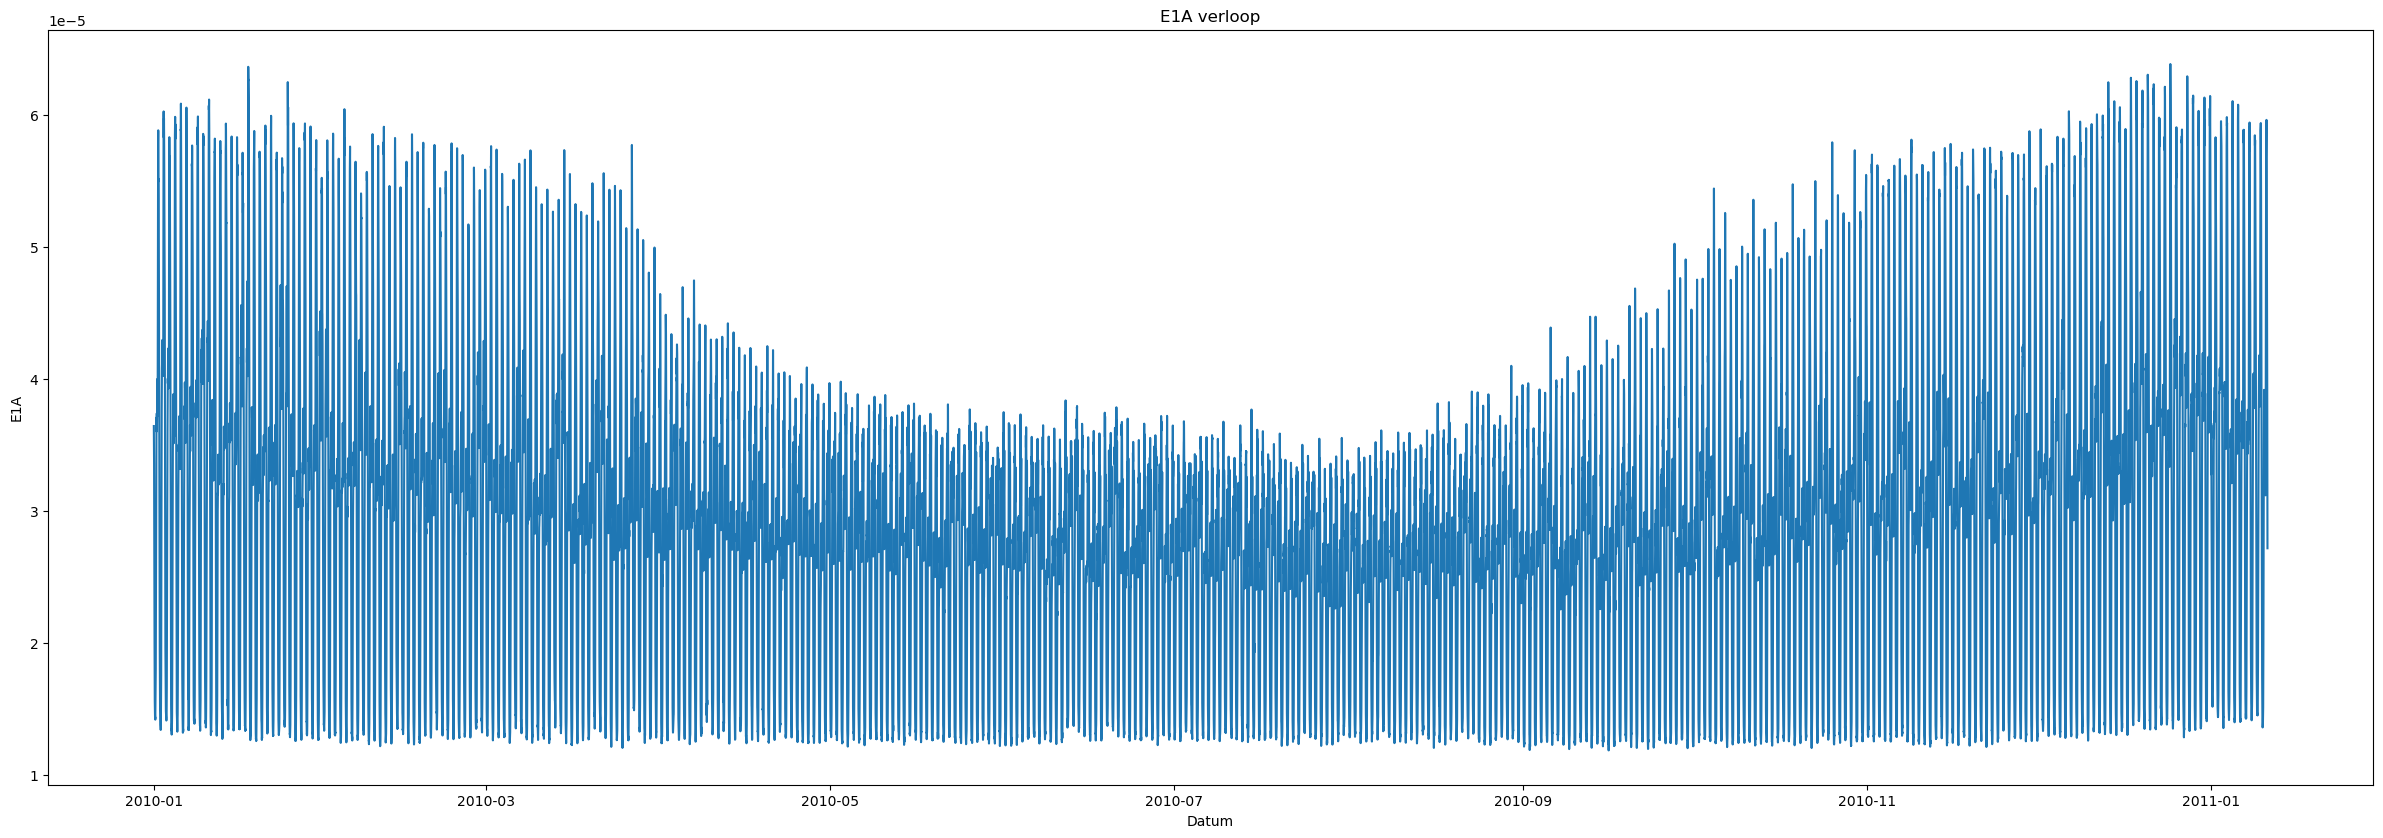

In [6]:
# Time series plot voor 2010. Controle of alle data visueel ook correct lijkt
plt.figure(figsize=(30,10), dpi=100)
plt.plot(combined_df[:36000].DatumTijd, combined_df[:36000].E1A, color='tab:blue')
plt.gca().set(title='E1A verloop', xlabel='Datum', ylabel='E1A')
plt.show()

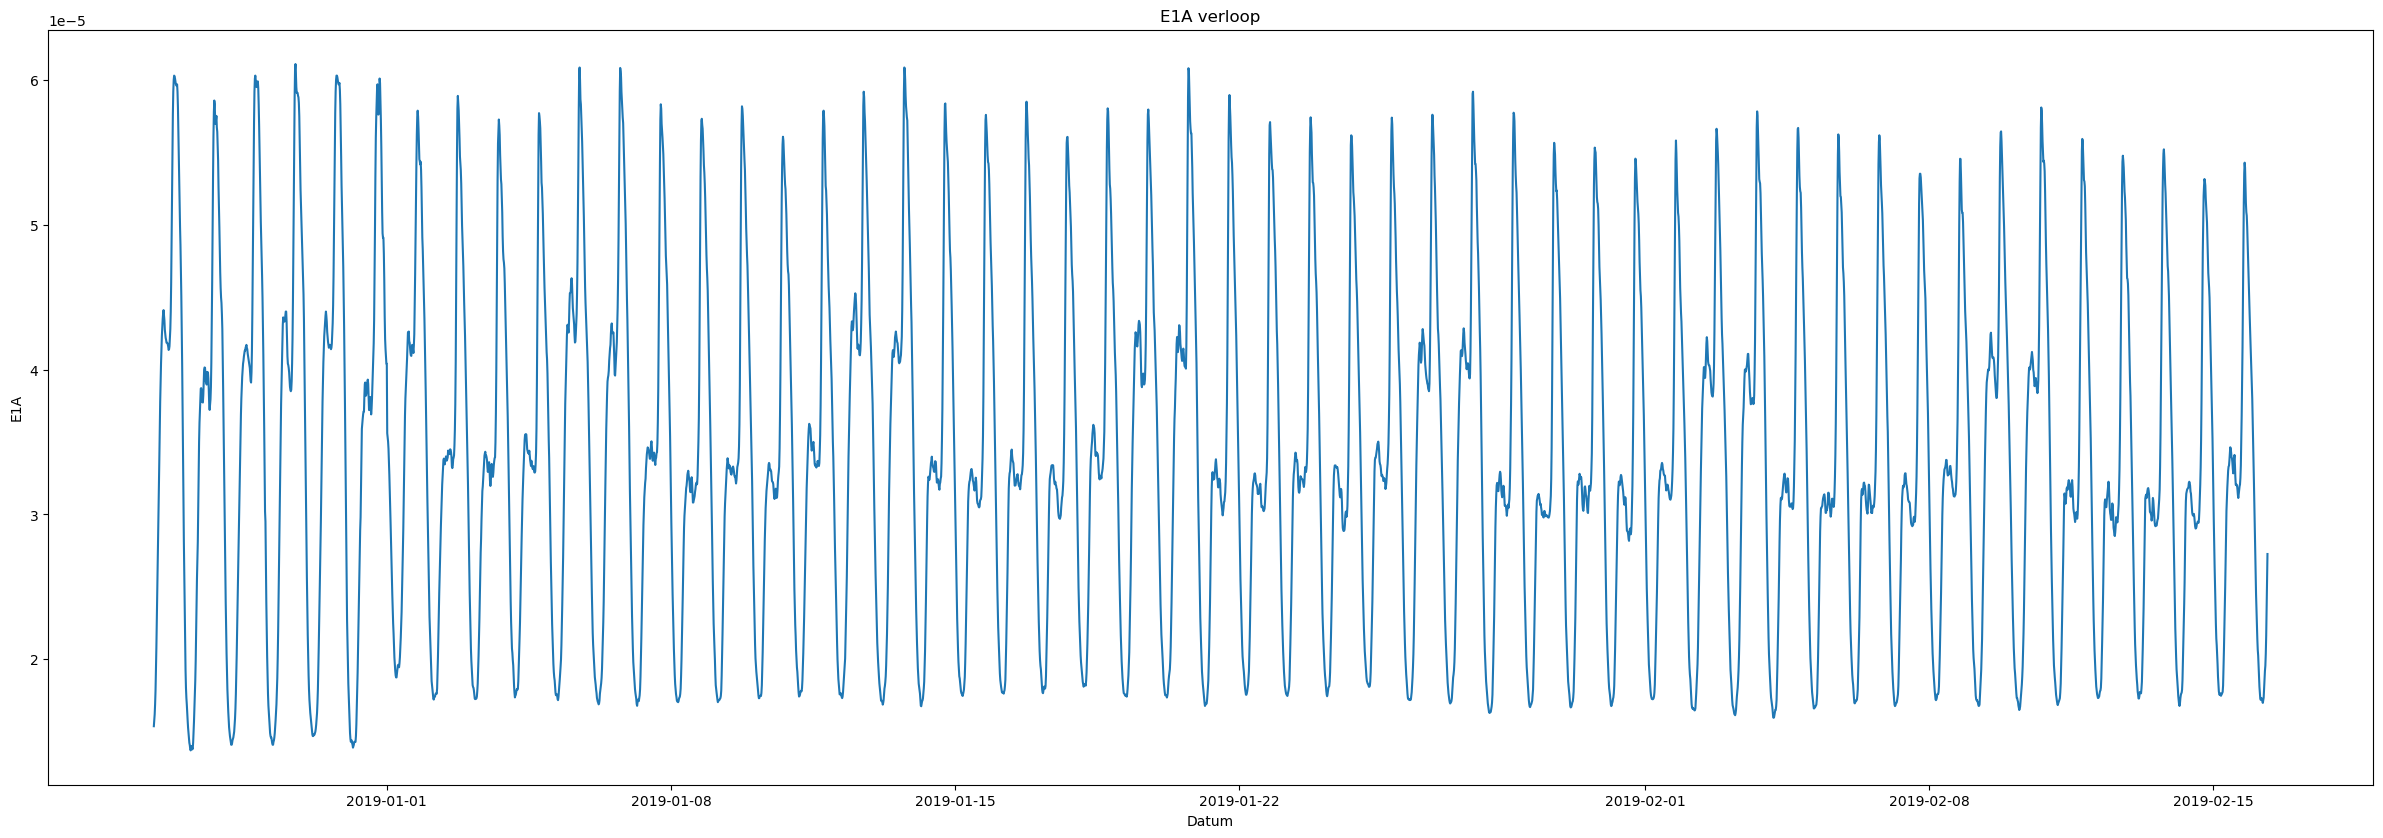

In [7]:
# Time series plot voor (een gedeelte van) 2019. Controle of alle data visueel ook correct lijkt
plt.figure(figsize=(30,10), dpi=100)
plt.plot(combined_df[315000:320000].DatumTijd, combined_df[315000:320000].E1A, color='tab:blue')
plt.gca().set(title='E1A verloop', xlabel='Datum', ylabel='E1A')
plt.show()

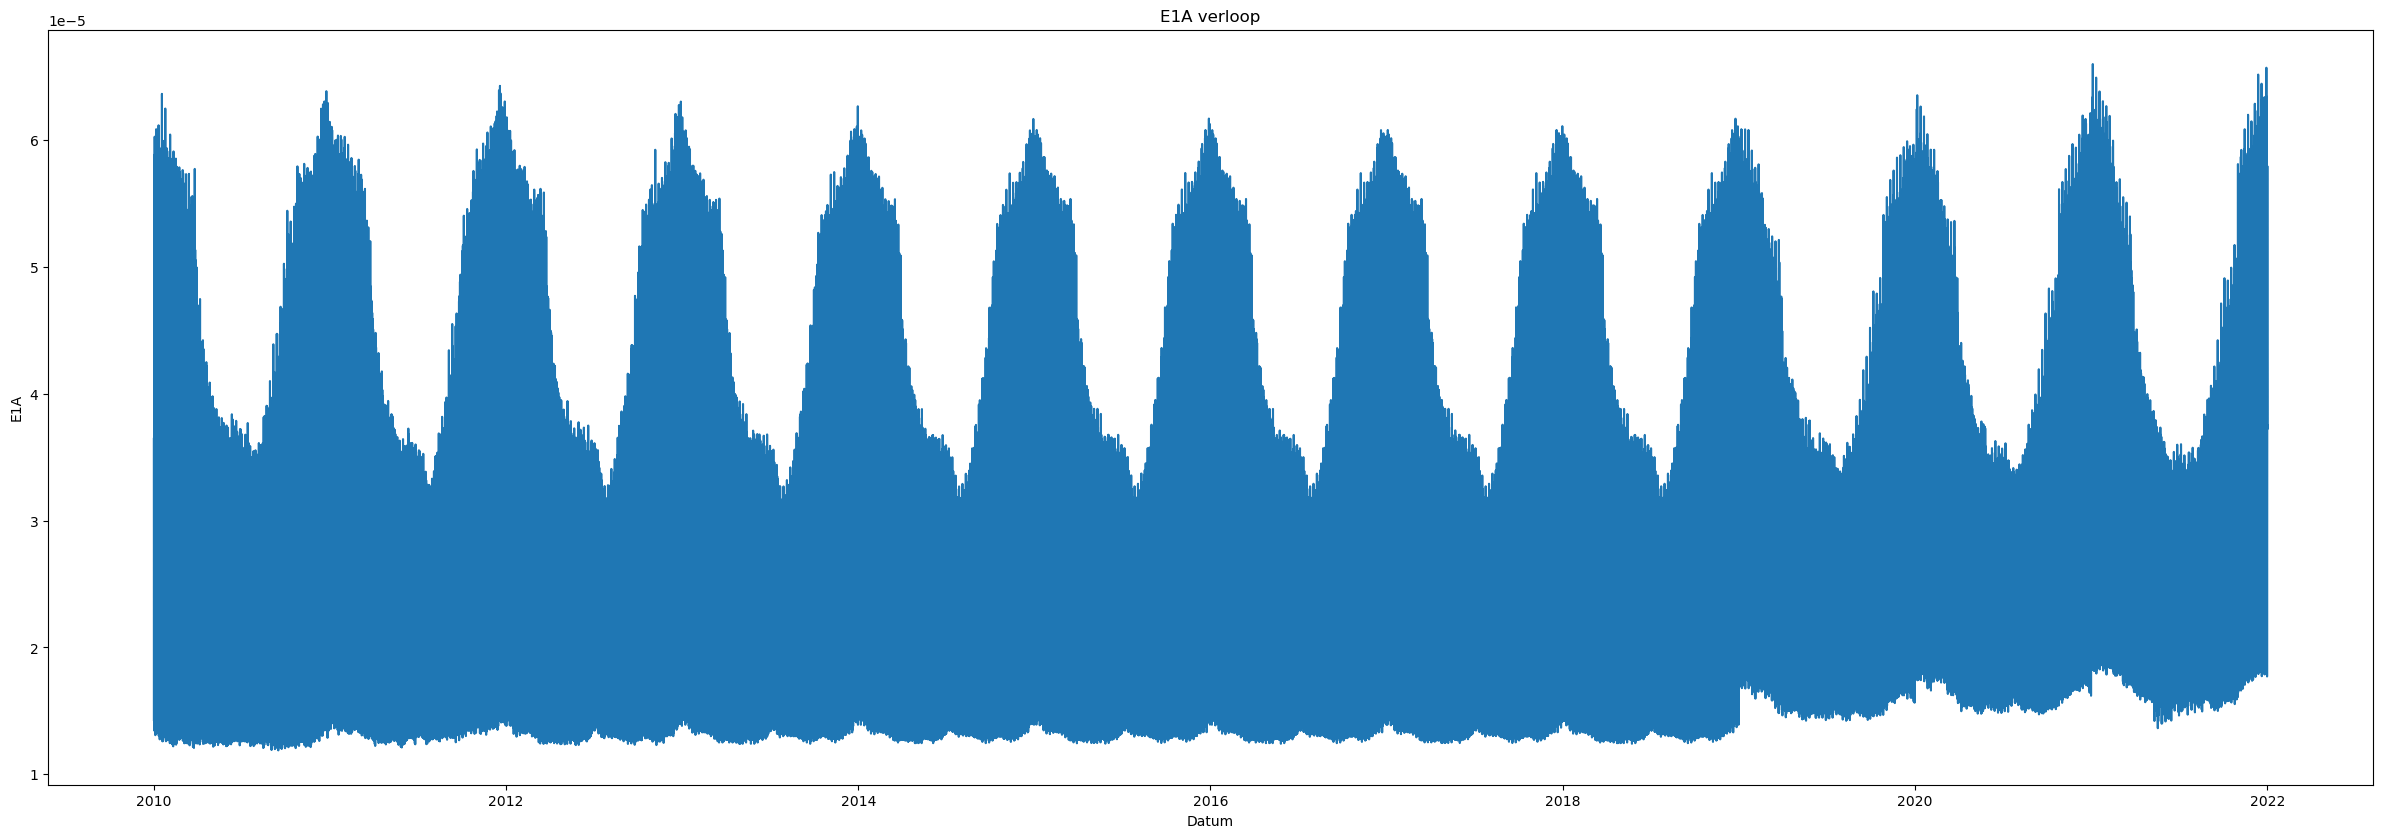

In [8]:
# Time series plot voor (een gedeelte van) 2019. Controle of alle data visueel ook correct lijkt
plt.figure(figsize=(30,10), dpi=100)
plt.plot(combined_df.DatumTijd, combined_df.E1A, color='tab:blue')
plt.gca().set(title='E1A verloop', xlabel='Datum', ylabel='E1A')
plt.show()

In [9]:
combined_df.DatumTijd.dt.year.value_counts()

2016.0    35136
2012.0    35136
2020.0    35136
2017.0    35040
2011.0    35040
2019.0    35040
2014.0    35040
2018.0    35040
2013.0    35040
2021.0    35040
2015.0    35040
2010.0    35039
2022.0        1
Name: DatumTijd, dtype: int64

In [10]:
combined_df.head(15)

,DatumTijd,E1A,E1B,E1C,E2A,E2B,E3A,E3B,E3C,E3D,E4A
0,2010-01-01 00:15:00,0.000036,0.000042,0.000039,0.000022,0.000026,0.000022,0.000019,0.000019,0.000025,0.00006
1,2010-01-01 00:30:00,0.000036,0.000040,0.000038,0.000024,0.000026,0.000024,0.000019,0.000019,0.000025,0.00006
2,2010-01-01 00:45:00,0.000036,0.000038,0.000038,0.000025,0.000025,0.000025,0.000019,0.000019,0.000025,0.00006
3,2010-01-01 01:00:00,0.000035,0.000037,0.000037,0.000024,0.000025,0.000024,0.000019,0.000019,0.000025,0.00006
4,2010-01-01 01:15:00,0.000034,0.000035,0.000037,0.000022,0.000024,0.000022,0.000019,0.000019,0.000025,0.00006
5,2010-01-01 01:30:00,0.000031,0.000034,0.000035,0.000021,0.000023,0.000021,0.000018,0.000018,0.000025,0.00006
6,2010-01-01 01:45:00,0.000030,0.000033,0.000033,0.000021,0.000023,0.000021,0.000018,0.000018,0.000025,0.00006
7,2010-01-01 02:00:00,0.000029,0.000031,0.000030,0.000021,0.000023,0.000021,0.000018,0.000018,0.000025,0.00006
8,2010-01-01 02:15:00,0.000027,0.000029,0.000028,0.000020,0.000022,0.000020,0.000018,0.000018,0.000025,0.00006
9,2010-01-01 02:30:00,0.000025,0.000028,0.000026,0.000021,0.000021,0.000021,0.000018,0.000018,0.000025,0.00006


In [11]:
# Bereken de index van de jaarovergang van 2010 naar 2011 om te controleren of de sortering heeft gewerkt
end_of_year = 4 * 24 * 365
combined_df[end_of_year-10:end_of_year+10]

,DatumTijd,E1A,E1B,E1C,E2A,E2B,E3A,E3B,E3C,E3D,E4A
35030,2010-12-31 21:45:00,0.000050,0.000046,0.000048,0.000025,0.000035,0.000025,0.000025,0.000025,0.000029,0.00006
35031,2010-12-31 22:00:00,0.000049,0.000045,0.000045,0.000025,0.000033,0.000025,0.000024,0.000024,0.000028,0.00006
35032,2010-12-31 22:15:00,0.000048,0.000044,0.000043,0.000024,0.000032,0.000024,0.000023,0.000023,0.000028,0.00006
35033,2010-12-31 22:30:00,0.000046,0.000043,0.000043,0.000023,0.000030,0.000023,0.000023,0.000023,0.000028,0.00006
35034,2010-12-31 22:45:00,0.000044,0.000042,0.000043,0.000022,0.000030,0.000022,0.000022,0.000022,0.000027,0.00006
35035,2010-12-31 23:00:00,0.000041,0.000043,0.000043,0.000022,0.000030,0.000022,0.000022,0.000022,0.000027,0.00006
35036,2010-12-31 23:15:00,0.000039,0.000044,0.000043,0.000022,0.000030,0.000022,0.000021,0.000021,0.000027,0.00006
35037,2010-12-31 23:30:00,0.000037,0.000044,0.000043,0.000023,0.000030,0.000023,0.000021,0.000021,0.000027,0.00006
35038,2010-12-31 23:45:00,0.000034,0.000041,0.000042,0.000022,0.000028,0.000022,0.000021,0.000021,0.000027,0.00006
35039,2011-01-01 00:00:00,0.000033,0.000038,0.000039,0.000022,0.000027,0.000022,0.000020,0.000020,0.000026,0.00006


In [12]:
# Controleer ook de jaarovergang van 2015 naar 2016
end_of_year = 5 * (4 * 24 * 365) + 4 * 24 * 366
combined_df[end_of_year-10:end_of_year+10]

,DatumTijd,E1A,E1B,E1C,E2A,E2B,E3A,E3B,E3C,E3D,E4A
210326,2015-12-31 21:45:00,0.000049,0.000046,0.000050,0.000028,0.000025,0.000019,0.000022,0.000022,0.000028,0.00006
210327,2015-12-31 22:00:00,0.000049,0.000045,0.000051,0.000027,0.000025,0.000019,0.000021,0.000021,0.000027,0.00006
210328,2015-12-31 22:15:00,0.000048,0.000044,0.000051,0.000026,0.000024,0.000019,0.000021,0.000021,0.000027,0.00006
210329,2015-12-31 22:30:00,0.000046,0.000044,0.000049,0.000025,0.000024,0.000019,0.000021,0.000021,0.000027,0.00006
210330,2015-12-31 22:45:00,0.000044,0.000044,0.000046,0.000024,0.000023,0.000019,0.000021,0.000021,0.000027,0.00006
210331,2015-12-31 23:00:00,0.000042,0.000044,0.000043,0.000023,0.000023,0.000019,0.000021,0.000021,0.000026,0.00006
210332,2015-12-31 23:15:00,0.000041,0.000042,0.000040,0.000023,0.000024,0.000019,0.000021,0.000021,0.000026,0.00006
210333,2015-12-31 23:30:00,0.000041,0.000041,0.000039,0.000023,0.000024,0.000019,0.000021,0.000021,0.000026,0.00006
210334,2015-12-31 23:45:00,0.000040,0.000041,0.000038,0.000024,0.000024,0.000019,0.000021,0.000021,0.000026,0.00006
210335,2016-01-01 00:00:00,0.000040,0.000040,0.000037,0.000023,0.000024,0.000019,0.000021,0.000021,0.000026,0.00006


In [13]:
# data locatie als we hier komen is 'temp_voor_EDU_files'
data_location = '../../data/processed'

# Ga naar de folder waarin de processed data staat
# Eenmaal chdir uitgevoerd blijft de current directory uiteraard 'processed'
if 'processed' not in os.getcwd():
    os.chdir(data_location)

In [14]:
try:
    os.remove('nedu_files.h5')
except:
    print ('File nog in gebruik of niet gevonden')

store = pd.HDFStore('nedu_files.h5')
store['nedu_files'] = combined_df
store.close()

In [15]:
# Gooi de temporary directory weg. Het dataframe is gemaakt en opgeslagen
data_location = '../../notebooks'

# Ga terug naar de notebooks directory
if 'notebooks' not in os.getcwd():
    os.chdir(data_location)

In [16]:
import shutil

try:
    # Gooi de tijdelijke directory weg. Het dataframe is gemaakt en opgeslagen
    shutil.rmtree(tmp_directory)
except OSError as e:
    print(f"Error: {tmp_directory} : {e.strerror}")